In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt

------------------------------------------------

Width: 32, Depth: 2

------------------------------------------------

Final Validation Loss: 148.1143798828125
Final Train Loss: 43.38041687011719

Final Validation Loss: 389.3962097167969
Final Train Loss: 274.7104187011719

Final Validation Loss: 48.52519607543945
Final Train Loss: 27.285320281982422

Final Validation Loss: 58.37058639526367
Final Train Loss: 44.610416412353516

Final Validation Loss: 228.84800720214844
Final Train Loss: 154.26992797851562

------------------------------------------------

Width: 32, Depth: 4

------------------------------------------------

Final Validation Loss: 49.0933837890625
Final Train Loss: 34.704833984375

Final Validation Loss: 9.436657905578613
Final Train Loss: 3.9720265865325928

Final Validation Loss: 158.1621551513672
Final Train Loss: 29.982011795043945

Final Validation Loss: 25.924720764160156
Final Train Loss: 17.104814529418945

Final Validation Loss: 19.416622161865234
Final Tra

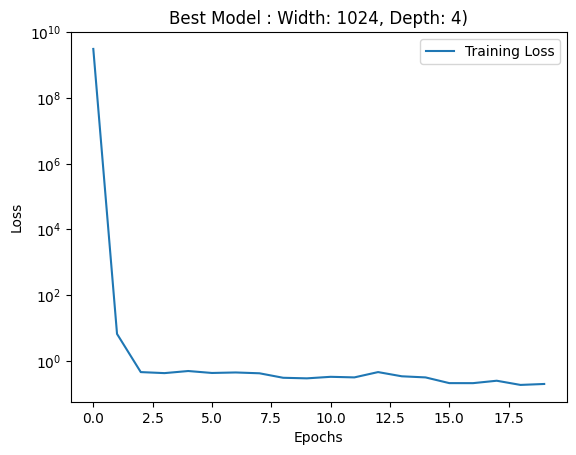

In [ ]:
train_df = pd.read_csv("https://raw.githubusercontent.com/bournenadia26/cs131/refs/heads/main/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/bournenadia26/cs131/refs/heads/main/test.csv")

# convert from df to np arr
X_train = train_df.drop(columns=['arousal']).to_numpy()
y_train = train_df['arousal'].to_numpy()
X_test = test_df.drop(columns=['arousal']).to_numpy()
y_test = test_df['arousal'].to_numpy()

# edited version of provided way to make model
def build(width, depth):  # width between 1024 and 32, depth between 2 and 4
    layers = [
        tf.keras.layers.Input(shape=(X_train.shape[1],))  # Input layer
    ]

    for i in range(depth):
        layers.append(tf.keras.layers.Dense(width, activation='relu'))  # Hidden layers

    layers.append(tf.keras.layers.Dense(1, activation='linear'))  # Output layer

    model = tf.keras.models.Sequential(
        layers=layers,
        name='Multi-layer_Perceptron'
    )

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

width_vals = [32,1024]  # values to test
depth_vals = [2,4]
avg_loss_list = []  # save for later
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for width in width_vals:  # to test values
  for depth in depth_vals:

    final_val_loss_list = []
    final_train_loss_list = []

    print("------------------------------------------------")
    print(f"\nWidth: {width}, Depth: {depth}\n")
    print("------------------------------------------------\n")

    for train_idx, val_idx in kfold.split(X_train):

      model = build(width,depth)  # run our build function

      # edited from provided way to train model
      history = model.fit(
        X_train[train_idx], # X
        y_train[train_idx], # y
        validation_data=(X_train[val_idx], y_train[val_idx]), # give val data specifically
        epochs=15,
        batch_size=8,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)]
      )

      #save final loss of iteration
      final_val_loss = history.history['val_loss'][-1]
      final_train_loss = history.history['loss'][-1]
      print(f"Final Validation Loss: {final_val_loss}")
      print(f"Final Train Loss: {final_train_loss}\n")
      final_val_loss_list.append(final_val_loss)
      final_train_loss_list.append(final_train_loss)


    # calculate avg
    avg_val_loss = np.mean(final_val_loss_list)
    avg_train_loss = np.mean(final_train_loss_list)
    avg_loss_list.append((width, depth, avg_val_loss, avg_train_loss))

best_val_loss = 10000000000000000
best_width = 0
best_depth = 0

print("\n------------------------------------------------")
for width, depth, avg_val_loss, avg_train_loss in avg_loss_list:
    print(f"Width: {width}, Depth: {depth}, Avg Val Loss: {avg_val_loss}, Avg Train Loss: {avg_train_loss}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

        best_width = width
        best_depth = depth

print("------------------------------------------------")
print(f"\nBest Validation Loss: {best_val_loss}, Width: {best_width}, Depth: {best_depth}\n")
print("------------------------------------------------\n")

# run it again for the final train loss
best_model = build(best_width,best_depth)
best_history = best_model.fit(
        X_train, # X
        y_train, # y
        epochs=20,
        batch_size=8,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)]
      )

final_train_loss = best_history.history['loss'][-1]
print(f"Final Train Loss: {final_train_loss}\n")
print("------------------------------------------------\n")

# plotting
plt.plot(best_history.history['loss'], label='Training Loss')
plt.yscale('log')
plt.title(f'Best Model : Width: {best_width}, Depth: {best_depth})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
